# CEWA 568 Snow Hydrology - Winter 2025
# Lab 2-1: SNOTEL data from the East River Valley

Written by Daniel Hogan - March 9, 2023


Modified by Eli Schwat in December 2024

-------------------------------------------
### Imports necessary for the notebook
A few packages may need to be installed including:
- contextily
- geopandas
- metloom
- xarray

If you are working on your own computer's python package, to install, go to the command line and type: 

`conda install -c conda-forge contextily geopandas metloom xarray`

If you are working on the UW Jupyterhub install, you will need to install locally each time you run these sections of the notebook.

In [1]:
!pip install metloom

In [2]:
import xarray as xr # used for storing our data
import matplotlib.pyplot as plt
import contextily as cx # this is for plotting 
import geopandas as gpd # for location information of snotel sites
import numpy as np

import pandas as pd
from datetime import datetime
import datetime as dt
from metloom.pointdata import SnotelPointData

-----------------------------------------------------
## SNOTEL sites and data within the East River Valley
-----------------------------------------------------



This lab will introduce you to the NRCS SNow TELemetry (SNOTEL) sites (Butte and Schofield Pass) within the East River valley near Crested Butte, CO. We will first introduce the area that we will be studying by building a basic basemap of the Upper East River valley. Then, we will pull in the SNOTEL data for Butte and Schofield Pass. Once we have this data, we'll add in a few variables and show a plot of snow water equivalent (SWE) for your choice of SNOTEL site and water year. Let's get started!

-----------------------------------------
### Introduction to the Upper East River Valley

Let's download data from two SNOTEL stations in the Upper East River Valley

Variables available for download include (see the SnotelVariables object here https://metloom.readthedocs.io/en/latest/api.html): 
* PRECIPITATION
* PRECIPITATIONACCUM
* RH
* SNOWDEPTH
* SOILMOISTURE20IN
* SOILMOISTURE2IN
* SOILMOISTURE4IN
* SOILMOISTURE8IN
* STREAMVOLUMEADJ
* STREAMVOLUMEOBS
* SWE
* TEMP
* TEMPAVG
* TEMPGROUND20IN
* TEMPGROUND2IN
* TEMPGROUND4IN
* TEMPGROUND8IN
* TEMPMAX
* TEMPMIN

In [3]:
snotel_point_butte = SnotelPointData("380:CO:SNTL", "Butte")
snotel_point_schofield = SnotelPointData("737:CO:SNTL", "Schofield Pass")

SNOTEL_VARS = [
    snotel_point_butte.ALLOWED_VARIABLES.PRECIPITATION,
    snotel_point_butte.ALLOWED_VARIABLES.TEMPAVG,
    snotel_point_butte.ALLOWED_VARIABLES.SWE,
    snotel_point_butte.ALLOWED_VARIABLES.SNOWDEPTH,
]

In [4]:
df_butte = snotel_point_butte.get_daily_data(
    datetime(2022, 11, 1), datetime(2023, 6, 19),
    SNOTEL_VARS
)
df_schofield = snotel_point_schofield.get_daily_data(
    datetime(2022, 11, 1), datetime(2023, 6, 19),
    SNOTEL_VARS
)

In [5]:
df_butte.head()

,,geometry,PRECIPITATION,PRECIPITATION_units,AVG AIR TEMP,AVG AIR TEMP_units,SWE,SWE_units,SNOWDEPTH,SNOWDEPTH_units,datasource
datetime,site,,,,,,,,,,
2022-11-01 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.1,in,33.80,degF,1.0,in,5.0,in,NRCS
2022-11-02 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.0,in,35.78,degF,1.0,in,5.0,in,NRCS
2022-11-03 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.4,in,25.16,degF,1.0,in,4.0,in,NRCS
2022-11-04 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.1,in,18.32,degF,1.4,in,9.0,in,NRCS
2022-11-05 08:00:00+00:00,380:CO:SNTL,POINT Z (-106.95327 38.89435 10200.00000),0.2,in,24.62,degF,1.5,in,9.0,in,NRCS


In [6]:
# Create a dataseries for the two locations of the snotels.
# Note we give it a "CRS" coordinate reference system which corresponds to the Latitude Longitude points provided in the dataframe above
snotel_loc = gpd.GeoSeries(
    [df_butte.geometry.iloc[0], df_schofield.geometry.iloc[0]],
    index = ['Butte', 'Schofield Pass'],
    crs = 'epsg:4326'
)
snotel_loc = snotel_loc.to_crs('epsg:32613')
snotel_loc

Butte             POINT Z (330604.668 4306865.963 10200.000)
Schofield Pass    POINT Z (322573.638 4320402.503 10653.000)
dtype: geometry

---------------------------------------
### Visualize the valley with a Basemap
(The code section below may take a minute or so to run.)

/Users/elischwat/miniforge3/envs/snow-hydrology/lib/python3.10/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/Users/elischwat/miniforge3/envs/snow-hydrology/lib/python3.10/site-packages/matplotlib/text.py:763: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(y))
/Users/elischwat/miniforge3/envs/snow-hydrology/lib/python3.10/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/elischwat/miniforge3/envs/snow-hydrology/lib/python3.10/site-packages/matplotlib/text.py:906: FutureWarning: Calling float on a single elemen

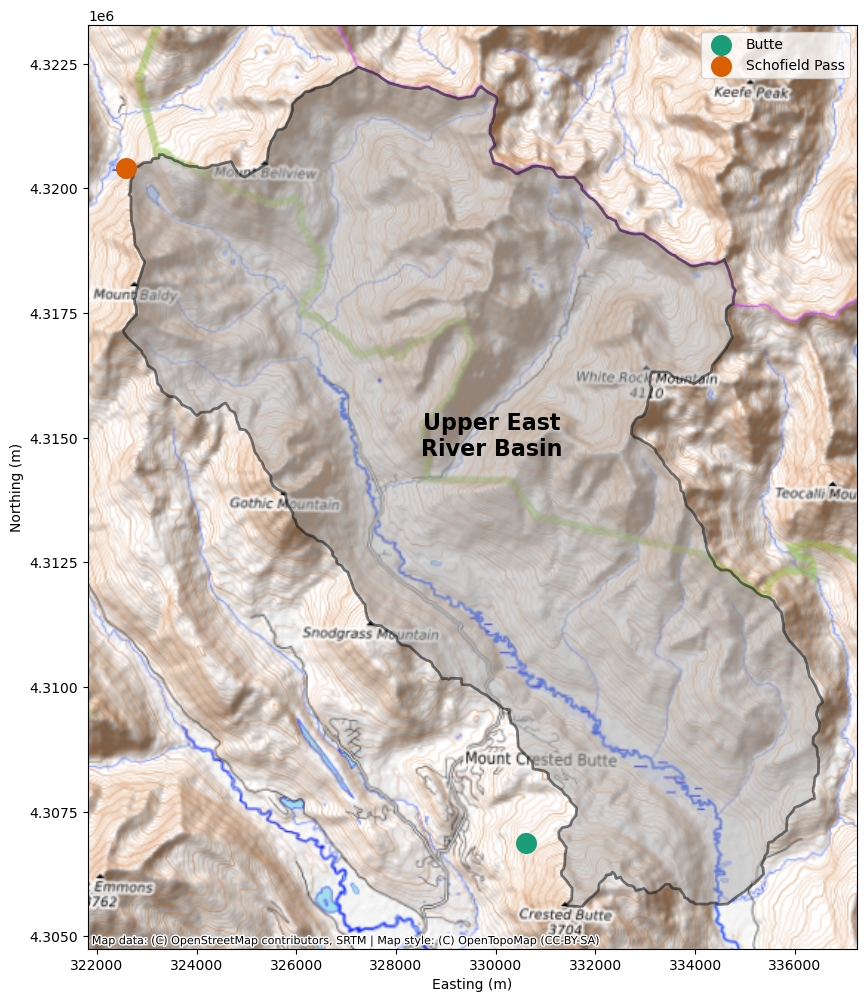

In [7]:
# Read in the Upper East River file
upper_east_river_polygon = gpd.read_file('./east_polygon.json')

cb_colors = ['#1b9e77','#d95f02','#7570b3']

# Initialize Figure
fig, ax = plt.subplots(figsize=(12,12))

# Plot Upper East River polygon
upper_east_river_polygon.plot(
        ax=ax, 
        color='darkgrey',
        alpha=0.5,
        zorder=1,
        edgecolor = 'black',
        linewidth=2
)

# Plot SNTL locations
snotel_loc.iloc[:1].plot(color=cb_colors[0], markersize= 200, ax=ax, label=snotel_loc.index[0])
snotel_loc.iloc[1:2].plot(color=cb_colors[1], markersize= 200, ax=ax, label=snotel_loc.index[1])

# Label the Upper East River Basin
ax.text(upper_east_river_polygon.centroid.x, upper_east_river_polygon.centroid.y,
        "Upper East\nRiver Basin",
        fontsize=16, 
        fontweight='bold',
        color='k',
        horizontalalignment='center')

# If downloading contextily is causing issues, comment the below line out
cx.add_basemap(ax=ax, crs=upper_east_river_polygon.crs.to_string(),source=cx.providers.OpenTopoMap);
# Add legend
ax.legend();
ax.set_xlabel('Easting (m)');
ax.set_ylabel('Northing (m)');

-----------------------------

Let's convert units from imperial to metric units and add them as an attribute

In [8]:
# converting from inches to cm
df_butte['PRECIPITATION'] = df_butte['PRECIPITATION']*2.54
df_butte['SWE'] = df_butte['SWE']*2.54
df_butte['SNOWDEPTH'] = df_butte['SNOWDEPTH']*2.54
# converting from ˚F to ˚C
df_butte['AVG AIR TEMP'] = (df_butte['AVG AIR TEMP'] - 32) * 5/9

df_schofield['PRECIPITATION'] = df_schofield['PRECIPITATION']*2.54
df_schofield['SWE'] = df_schofield['SWE']*2.54
df_schofield['SNOWDEPTH'] = df_schofield['SNOWDEPTH']*2.54
df_schofield['AVG AIR TEMP'] = (df_schofield['AVG AIR TEMP'] - 32) * 5/9

# Plot snow water equivalent for the water year at both stations

In [9]:
df_schofield.index = df_schofield.index.droplevel(1)
df_butte.index = df_butte.index.droplevel(1)

Text(0.5, 1.0, 'SWE for Water Year 2022-2023')

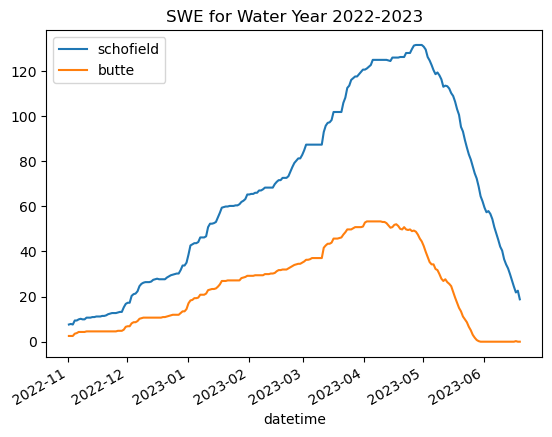

In [10]:
df_schofield['SWE'].plot(label='schofield')
df_butte['SWE'].plot(label='butte')
plt.legend()
plt.title("SWE for Water Year 2022-2023")

## Plotting SWE data from the SOS campaign